# Policy iteration

In [1]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import gym

## Cliff Walking environment

https://www.gymlibrary.dev/environments/toy_text/cliff_walking/

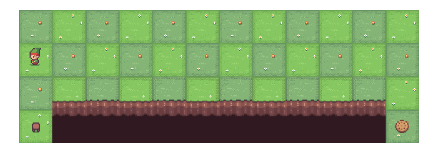

The board is a 4x12 matrix, with (using NumPy matrix indexing):
- [3, 0] as the start at bottom-left
- [3, 11] as the goal at bottom-right
- [3, 1..10] as the cliff at bottom-center

If the agent steps on the cliff, it returns to the start. An episode terminates when the agent reaches the goal.

There are 4 discrete deterministic actions:
- 0: move up
- 1: move right
- 2: move down
- 3: move left



In [2]:
env = gym.make("CliffWalking-v0")

/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [3]:
print(env.observation_space), print(env.action_space)

Discrete(48)
Discrete(4)


(None, None)

In [4]:
P = env.P
# for each state s, P[s] is a dictionary with each of the 4 actions as keys
# for each of 4 actions, the value is a tuple (prob, next_state, reward, done)
print(P[0])

{0: [(1.0, 0, -1, False)], 1: [(1.0, 1, -1, False)], 2: [(1.0, 12, -1, False)], 3: [(1.0, 0, -1, False)]}


## Policy improvement

### Helper functions

In [5]:
  def greedification(value_function):

    policy = np.zeros(env.observation_space.n, dtype=int)

    for state in range(env.observation_space.n-1):
        next_values = [value_function[x[0][1]]+x[0][2] for x in env.P[state].values()]
        policy[state] = np.argmax(next_values)

    return policy

  def print_policy(policy):
    mapping = {
        0: "\u2191",
        1: "\u2192",
        2: "\u2193",
        3: "\u2190"
    }
    arr = np.vectorize(mapping.get)(policy)
    arr[-1] = "🏁"
    print(arr.reshape(4,12))

### Policy iteration

In [19]:
env.reset()

#Define parameters
discount_factor = 0.9
max_iterations = 100
max_eval_iterations = 50

#Initialize the policy and value function with zeros
policy = np.zeros(env.observation_space.n, dtype=int)
value_function = np.zeros(env.observation_space.n)

#Perform policy iteration
for i in range(max_iterations):

  new_value_function = np.zeros(env.observation_space.n)
  
  # Policy evaluation
  for _ in range(max_eval_iterations):
    for state in range(env.observation_space.n-1):
        # Determine next state based on current policy
        _, next_state, reward, done = env.P[state][policy[state]][0]
        if state in np.arange(37,47): # cliff!
            new_value_function[state] = -100 + discount_factor * value_function[36]
        else:
            new_value_function[state] = reward + discount_factor * value_function[next_state]

    if np.all(np.isclose(value_function, new_value_function)): break

  value_function = new_value_function

  # Policy improvement (greedy)
  new_policy = greedification(value_function)

  
  if np.all(policy==new_policy):
    break
  
  policy = new_policy

In [20]:
value_matrix = value_function.round(2).reshape(4,12)
print(value_matrix)

[[  -7.71   -7.46   -7.18   -6.86   -6.51   -6.13   -5.7    -5.22   -4.69
    -4.1    -3.44   -2.71]
 [  -7.46   -7.18   -6.86   -6.51   -6.13   -5.7    -5.22   -4.69   -4.1
    -3.44   -2.71   -1.9 ]
 [  -7.18   -6.86   -6.51   -6.13   -5.7    -5.22   -4.69   -4.1    -3.44
    -2.71   -1.9    -1.  ]
 [  -7.46 -106.71 -106.71 -106.71 -106.71 -106.71 -106.71 -106.71 -106.71
  -106.71 -106.71    0.  ]]


In [21]:
print_policy(policy)

[['→' '→' '→' '→' '→' '→' '→' '→' '→' '→' '→' '↓']
 ['→' '→' '→' '→' '→' '→' '→' '→' '→' '→' '→' '↓']
 ['→' '→' '→' '→' '→' '→' '→' '→' '→' '→' '→' '↓']
 ['↑' '↑' '↑' '↑' '↑' '↑' '↑' '↑' '↑' '↑' '→' '🏁']]


### Value iteration

In [32]:
env.reset()

# Define parameters
discount_factor = 0.9
num_iterations = 1000

# Initialize the value function with zeros
value_function = np.zeros(env.observation_space.n)

# Perform value iteration
for i in range(num_iterations):
    new_value_function = np.zeros(env.observation_space.n)
    for state in range(env.observation_space.n-1):
        for action in range(env.action_space.n):
          possible_states = [x[0][1] for x in env.P[state].values()]
          best_action = np.argmax(value_function[possible_states])
        # deterministic actions
        _, next_state, reward, done = env.P[state][best_action][0]
        if state in np.arange(37,47): # cliff!
            new_value_function[state] = -100 + discount_factor * value_function[36]
        else:
          new_value_function[state] = reward + discount_factor * value_function[next_state]

    if np.all(np.isclose(value_function,new_value_function, 1e-5)): 
      print(f"Converged at {i} iterations")
      break

    value_function = new_value_function

Converged at 14 iterations


In [34]:
value_matrix = value_function.round(2).reshape(4,12)
print(value_matrix)

[[  -7.71   -7.46   -7.18   -6.86   -6.51   -6.13   -5.7    -5.22   -4.69
    -4.1    -3.44   -2.71]
 [  -7.46   -7.18   -6.86   -6.51   -6.13   -5.7    -5.22   -4.69   -4.1
    -3.44   -2.71   -1.9 ]
 [  -7.18   -6.86   -6.51   -6.13   -5.7    -5.22   -4.69   -4.1    -3.44
    -2.71   -1.9    -1.  ]
 [  -7.46 -106.71 -106.71 -106.71 -106.71 -106.71 -106.71 -106.71 -106.71
  -106.71 -106.71    0.  ]]


In [35]:
print_policy(greedification(value_function))

[['→' '→' '→' '→' '→' '→' '→' '→' '→' '→' '→' '↓']
 ['→' '→' '→' '→' '→' '→' '→' '→' '→' '→' '→' '↓']
 ['→' '→' '→' '→' '→' '→' '→' '→' '→' '→' '→' '↓']
 ['↑' '↑' '↑' '↑' '↑' '↑' '↑' '↑' '↑' '↑' '→' '🏁']]
